# Music Emotion Tracking Based On Audio And Lyrics

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1. Data Collection

In [2]:
import requests

### 1.1 Import the index list

In [3]:
train_df = pd.read_csv("Dataset_index_list/train.csv")
val_df = pd.read_csv("Dataset_index_list/validation.csv")
test_df = pd.read_csv("Dataset_index_list/test.csv")

In [4]:
Index_table_df = pd.concat([train_df,val_df,test_df])
Index_table_df['dzr_sng_id'] = pd.to_numeric(Index_table_df['dzr_sng_id'])
Index_table_df = Index_table_df.sort_values("dzr_sng_id").reset_index().drop(columns=["index"])

In [5]:
Index_table_df

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name
0,213754,SORORTY12A67ADD67E,TRJIEJX12903CF2202,-0.682725,0.316758,Dark Tranquillity,Insanity's Crescendo
1,216237,SOSMRCK12AB0182619,TRWKHHA128F932CE8D,-1.176640,-0.314720,CALLA,Strangler
2,216752,SOVJXGK12A8AE4760C,TRLBHVY128F4242C31,-1.400403,1.538229,Anorexia Nervosa,Stabat mater dolorosa
3,221547,SOTMVNN12A8C139FA0,TRPXLVY128F425A9DB,0.482478,-0.471437,Gun Club,Sex beat
4,221613,SOBXMEQ12A58A7792D,TRGRCHN128F933DE2F,-0.780962,-0.789480,The Box Tops,The Letter
...,...,...,...,...,...,...,...
18639,117581660,SOIIDJM12AB017AFEB,TRQSIQV128F93085B3,-0.793515,-0.202252,Pink Floyd,Comfortably Numb
18640,117581964,SOEUIUI12A58A7CD98,TRKUOAS128F1478DC9,0.373325,-0.923151,Pink Floyd,Money
18641,120730030,SOLBMAO12D021984E4,TRLCQRI128F92F5EE4,0.034953,-0.689612,Jeff Buckley,Calling You
18642,123783366,SOAMEMR12A6D223C17,TRWQNDS12903CB318B,-1.935250,-0.655810,Billy Ocean,Love Really Hurts Without You


### 1.2 Extracing the audio files from the internet

In [ ]:
for ID in range(len(Index_table_df)):
    deezer = str(Index_table_df["dzr_sng_id"][ID])
    URL = "https://api.deezer.com/track/"+deezer
    r = requests.get(url = URL)
    te = r.json()
    mp3 = te['preview']
    if(mp3!=""):
        r = requests.get(mp3)
        filename = deezer+".mp3"
        path = 'Audio_dataset/'+filename 
        with open(path,'wb') as f: 
            f.write(r.content)

## 2. Music Emotion Detection based on Audio

In [100]:
import librosa
import time

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### 2.1 Data Pre-processing

In [7]:
file_data = [f for f in listdir("Audio_dataset")]

#### 2.1.1 Audio Sampling & Feature Extraction

In [ ]:
songname_vector = [] #song name 
tempo_vector = [] #tempo 
total_beats = []  #Total beats 
average_beats = []  #average beats
chroma_stft_mean = [] #pitches mean
chroma_cq_mean = [] #pitches mean 
chroma_cens_mean = [] #mean 
mel_mean = []      #melspectrogram
mfcc_mean = [] 
mfcc_delta_mean = [] 
rms_mean = []  #Time domain: Root mean square 
cent_mean = [] #Spectral Centroid 
spec_bw_mean = [] #spectral bandwidth
contrast_mean = [] #Spectral contrast 
rolloff_mean = [] #Spectral rolloff
poly_mean = [] #Polyrhythmic
tonnetz_mean = [] #The Tonal Centroids (or Tonnetz) 
zcr_mean = []  #zero-cross rate: Time domain
harm_mean = []  #Harmonic sounds 
perc_mean = []  # percussive
frame_mean = []

In [ ]:
start_time = time.time()

count=0
for audio in file_data:
    songname = "Audio_dataset/"+audio
    y, sr = librosa.load(songname)
    S = np.abs(librosa.stft(y))
    feature_list=[]
    
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)          # Rhythmic features
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr) # Spectral features
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)                              # Temporal features 
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    poly_features = librosa.feature.poly_features(S=S, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    harmonic = librosa.effects.harmonic(y)                      # Audio Effects 
    percussive = librosa.effects.percussive(y)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    frames_to_time = librosa.frames_to_time(onset_frames[:20], sr=sr)
    
    songname_vector.append(audio)  # song name
    tempo_vector.append(tempo)   # tempo
    total_beats.append(sum(beats))   # beats
    average_beats.append(np.average(beats)) 
    mel_mean.append(np.mean(melspectrogram))   # melspectrogram
    mfcc_mean.append(np.mean(mfcc))   # mfcc
    mfcc_delta_mean.append(np.mean(mfcc_delta))   # mfcc delta
    chroma_stft_mean.append(np.mean(chroma_stft)) #pitches mean
    chroma_cq_mean.append(np.mean(chroma_cq)) #pitches mean 
    chroma_cens_mean.append(np.mean(chroma_cens))
    rms_mean.append(np.mean(rms))   # rms
    cent_mean.append(np.mean(cent))
    spec_bw_mean.append(np.mean(spec_bw))
    contrast_mean.append(np.mean(contrast))
    rolloff_mean.append(np.mean(rolloff))
    poly_mean.append(np.mean(poly_features))
    tonnetz_mean.append(np.mean(tonnetz))
    zcr_mean.append(np.mean(zcr))   # zero crossing rate
    harm_mean.append(np.mean(harmonic))   # harmonic
    perc_mean.append(np.mean(percussive))   # percussive
    frame_mean.append(np.mean(frames_to_time)) # frames
    
    count+=1
    print(f"Processing audio number: {count}, Process completed: {round(count/len(file_data)*100)}%",end="\r",flush=True)
    
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
feature_1_df = pd.DataFrame(songname_vector,columns=["song_name"])
feature_2_df = pd.DataFrame(tempo_vector,columns=["tempo"])
feature_3_df = pd.DataFrame(total_beats,columns=["total_beats"])
feature_4_df = pd.DataFrame(average_beats,columns=["average_beats"])
feature_5_df = pd.DataFrame(chroma_stft_mean,columns=["chroma_stft_mean"])
feature_6_df = pd.DataFrame(chroma_cq_mean,columns=["chroma_cq_mean"])
feature_7_df = pd.DataFrame(chroma_cens_mean,columns=["chroma_cens_mean"])
feature_8_df = pd.DataFrame(mel_mean,columns=["melspectrogram_mean"])
feature_9_df = pd.DataFrame(mfcc_mean,columns=["mfcc_mean"])
feature_10_df = pd.DataFrame(mfcc_delta_mean,columns=["mfcc_delta_mean"])
feature_11_df = pd.DataFrame(rms_mean,columns=["rms_mean"])
feature_12_df = pd.DataFrame(cent_mean,columns=["cent_mean"])
feature_13_df = pd.DataFrame(spec_bw_mean,columns=["spec_bw_mean"])
feature_14_df = pd.DataFrame(contrast_mean,columns=["contrast_mean"])
feature_15_df = pd.DataFrame(rolloff_mean,columns=["rolloff_mean"])
feature_16_df = pd.DataFrame(poly_mean,columns=["poly_mean"])
feature_17_df = pd.DataFrame(tonnetz_mean,columns=["tonnetz_mean"])
feature_18_df = pd.DataFrame(zcr_mean,columns=["zcr_mean"])
feature_19_df = pd.DataFrame(harm_mean,columns=["harm_mean"])
feature_20_df = pd.DataFrame(perc_mean,columns=["perc_mean"])
feature_21_df = pd.DataFrame(frame_mean,columns=["frame_mean"])

feature_set_df = pd.concat([feature_1_df,feature_2_df,feature_3_df,feature_4_df,feature_5_df,feature_6_df,
                            feature_7_df,feature_8_df,feature_9_df,feature_10_df,feature_11_df,feature_12_df,
                            feature_13_df,feature_14_df,feature_15_df,feature_16_df,feature_17_df,feature_18_df,
                            feature_19_df,feature_20_df,feature_21_df],axis=1)

#### 2.1.2 Data storage and management

In [1005]:
execution_time/3600

12.260805932614538

In [1184]:
feature_set_df.to_csv("Extracted_Audio_Features.csv")

In [8]:
feature_set_df = pd.read_csv("Extracted_Audio_Features.csv").drop(columns=["Unnamed: 0"])
feature_set_df

,song_name,tempo,total_beats,average_beats,chroma_stft_mean,chroma_cq_mean,chroma_cens_mean,melspectrogram_mean,mfcc_mean,mfcc_delta_mean,...,cent_mean,spec_bw_mean,contrast_mean,rolloff_mean,poly_mean,tonnetz_mean,zcr_mean,harm_mean,perc_mean,frame_mean
0,216237.mp3,143.554688,39971,605.621212,0.477182,0.353398,0.233380,16.789152,7.484647,0.010117,...,2657.424545,2773.192659,19.146447,5947.747368,2.974400,0.007125,0.093373,6.173348e-06,-0.000064,9.174204
1,221547.mp3,92.285156,23427,571.390244,0.424317,0.569171,0.271161,2.569507,0.406046,0.014021,...,2641.196705,2400.905278,19.208029,5262.609844,1.741521,0.003172,0.152013,-8.964933e-04,-0.002083,4.669533
2,221547.mp3,92.285156,23427,571.390244,0.424317,0.569171,0.271161,2.569507,0.406046,0.014021,...,2641.196705,2400.905278,19.208029,5262.609844,1.741521,0.003172,0.152013,-8.964933e-04,-0.002083,4.669533
3,221613.mp3,151.999081,46104,631.561644,0.374804,0.476727,0.259843,4.652390,2.166909,0.009293,...,2221.544440,2297.712556,21.716478,4578.338982,1.970450,0.025997,0.108279,1.447415e-07,-0.000008,3.906757
4,239138.mp3,78.302557,22523,608.729730,0.318959,0.351747,0.234316,0.713819,-7.750523,0.004965,...,2032.503843,2030.422139,22.763647,4035.425598,0.487379,0.015352,0.091427,-1.611942e-07,-0.000002,2.568127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,114388304.mp3,143.554688,45641,633.902778,0.350501,0.491704,0.265764,6.772540,3.550924,0.012562,...,2554.290751,2568.788103,21.376898,5483.450176,2.586164,0.019253,0.123793,6.791266e-06,0.000114,3.073161
16939,114388304.mp3,143.554688,45641,633.902778,0.350501,0.491704,0.265764,6.772540,3.550924,0.012562,...,2554.290751,2568.788103,21.376898,5483.450176,2.586164,0.019253,0.123793,6.791266e-06,0.000114,3.073161
16940,114388306.mp3,143.554688,44389,634.128571,0.352210,0.333468,0.220596,2.518630,1.164165,0.010989,...,1571.765866,2106.564184,22.098422,3421.070980,1.063929,-0.009213,0.054690,-3.122529e-06,0.000006,2.345215
16941,114388348.mp3,129.199219,39334,624.349206,0.347439,0.375479,0.241097,10.645028,3.497201,0.006597,...,2248.519868,2514.071508,21.796587,4975.219916,2.682056,0.043293,0.091127,5.631146e-06,0.000401,3.898630


#### 2.1.3 Interpret valence-arousal scale to emotion labels

In [9]:
audio_file = feature_set_df["song_name"].values
ID_list=[]
for file in audio_file:
    num = file.split(".")[0]
    ID_list.append(num)

valence_arousal_df = pd.DataFrame()
for num in ID_list:
    if (int(num) in Index_table_df["dzr_sng_id"].values):
        valence_arousal_df = pd.concat([valence_arousal_df,Index_table_df[Index_table_df["dzr_sng_id"]==int(num)]])
        
valence_arousal_df = valence_arousal_df.reset_index().drop(columns=["index"])

In [10]:
valence_arousal_df

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name
0,216237,SOSMRCK12AB0182619,TRWKHHA128F932CE8D,-1.176640,-0.314720,CALLA,Strangler
1,221547,SOTMVNN12A8C139FA0,TRPXLVY128F425A9DB,0.482478,-0.471437,Gun Club,Sex beat
2,221547,SOTMVNN12A8C139FA0,TRPXLVY128F425A9DB,0.482478,-0.471437,Gun Club,Sex beat
3,221613,SOBXMEQ12A58A7792D,TRGRCHN128F933DE2F,-0.780962,-0.789480,The Box Tops,The Letter
4,239138,SOACXLC12AB018218D,TRQJZHB128F92FA42D,-1.935250,-0.655810,Jimmy Witherspoon,Ain't Nobody's Business
...,...,...,...,...,...,...,...
16938,114388304,SOACEJK12A8C136E19,TRUOTTN128F425C099,1.178325,1.183311,Van Morrison,Wild Night
16939,114388304,SOACEJK12A8C136E19,TRUOTTN128F425C099,1.178325,1.183311,Van Morrison,Wild Night
16940,114388306,SOTWLJL12A58A7DA90,TRQOBCM128F428EA6E,0.373325,-0.923151,Van Morrison,Tupelo Honey
16941,114388348,SOVDDUT12A8C13B81D,TRHSGAZ128F428EA74,0.815393,0.662457,Van Morrison,Once In A Blue Moon


In [12]:
label_list=[]
for index in range(len(valence_arousal_df)):
    if (valence_arousal_df["valence"][index]>=0):
        if (valence_arousal_df["arousal"][index]>=0):
            label_list.append("happy")
        else:
            label_list.append("Relaxed")
    else:
        if (valence_arousal_df["arousal"][index]>=0):
            label_list.append("angry")
        else:
            label_list.append("sad")
            
feature_df = feature_set_df.drop(columns=["song_name"])
label_df = pd.DataFrame(label_list,columns=["Labels"])
Dataset_df = pd.concat([feature_df,label_df],axis=1)

#### 2.1.4 Normalization

In [13]:
Normalized_feature_df = pd.DataFrame()
max_list = []
min_list = []
for i in feature_df.columns:
    max_ = np.amax(feature_df[i])
    min_ = np.amin(feature_df[i])
    max_list.append(max_)
    min_list.append(min_)
    normlist = (feature_df[i]-min_)/(max_-min_)
    Normalized_feature_df = pd.concat([Normalized_feature_df,normlist],axis=1).fillna(0)
Norm_Dataset_df = pd.concat([Normalized_feature_df,label_df],axis=1)
Norm_Dataset_df

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_cq_mean,chroma_cens_mean,melspectrogram_mean,mfcc_mean,mfcc_delta_mean,rms_mean,...,spec_bw_mean,contrast_mean,rolloff_mean,poly_mean,tonnetz_mean,zcr_mean,harm_mean,perc_mean,frame_mean,Labels
0,0.575758,0.594284,0.688983,0.585124,0.344235,0.658842,0.348032,0.902112,0.565822,0.555243,...,0.755270,0.211960,0.707167,0.417952,0.438536,0.245544,0.615201,0.441682,0.357931,sad
1,0.272727,0.348292,0.649846,0.479772,0.731195,0.916904,0.052424,0.666334,0.634081,0.213371,...,0.625721,0.217286,0.617717,0.236732,0.426235,0.436399,0.595846,0.357030,0.180837,Relaxed
2,0.272727,0.348292,0.649846,0.479772,0.731195,0.916904,0.052424,0.666334,0.634081,0.213371,...,0.625721,0.217286,0.617717,0.236732,0.426235,0.436399,0.595846,0.357030,0.180837,Relaxed
3,0.625668,0.685476,0.718640,0.381103,0.565409,0.839601,0.095724,0.724986,0.551421,0.287432,...,0.589812,0.434250,0.528380,0.270382,0.497258,0.294059,0.615072,0.444020,0.150850,sad
4,0.190083,0.334850,0.692537,0.269813,0.341275,0.665238,0.013846,0.394650,0.475762,0.072322,...,0.496801,0.524823,0.457499,0.052386,0.464136,0.239212,0.615065,0.444268,0.098223,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,0.575758,0.678592,0.721317,0.332671,0.592269,0.880044,0.139799,0.771085,0.608564,0.361797,...,0.684141,0.404879,0.646550,0.360885,0.476274,0.344550,0.615214,0.449137,0.118078,happy
16939,0.575758,0.678592,0.721317,0.332671,0.592269,0.880044,0.139799,0.771085,0.608564,0.361797,...,0.684141,0.404879,0.646550,0.360885,0.476274,0.344550,0.615214,0.449137,0.118078,happy
16940,0.575758,0.659976,0.721575,0.336077,0.308493,0.571525,0.051366,0.691586,0.581077,0.195986,...,0.523296,0.467286,0.377290,0.137133,0.387697,0.119644,0.615002,0.444618,0.089460,Relaxed
16941,0.490909,0.584813,0.710394,0.326568,0.383834,0.711559,0.220304,0.769296,0.504285,0.440526,...,0.665101,0.441179,0.580196,0.374980,0.551079,0.238234,0.615189,0.461173,0.150530,happy


#### 2.1.5 Dimension Reduction

In [14]:
feature_title_list=[]
for i in range(len(Norm_Dataset_df)):
    feature = "Feature "+str(i)
    feature_title_list.append(feature)

In [15]:
components_number = 18
pca = PCA(n_components=components_number)
pca.fit(Normalized_feature_df)

data_after_PCA = pca.transform(Normalized_feature_df)
PCA_Data_df = pd.DataFrame(data_after_PCA,columns=feature_title_list[:components_number])
PCA_Data_df = pd.concat([PCA_Data_df,label_df],axis=1)
PCA_Data_df

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Labels
0,-0.286941,0.186509,0.122181,-0.248088,0.102409,0.220040,0.021669,0.110651,-0.060072,0.061270,0.073492,0.027128,-0.042433,-0.018443,0.045480,0.009086,-0.013586,0.001872,sad
1,-0.166396,-0.353817,-0.280019,0.210233,0.130181,0.056643,0.025925,-0.060976,0.070932,0.036022,-0.049060,0.056004,0.041594,-0.059567,0.040141,-0.010273,0.000517,-0.012798,Relaxed
2,-0.166396,-0.353817,-0.280019,0.210233,0.130181,0.056643,0.025925,-0.060976,0.070932,0.036022,-0.049060,0.056004,0.041594,-0.059567,0.040141,-0.010273,0.000517,-0.012798,Relaxed
3,0.044680,0.188420,-0.237298,0.093113,0.027773,-0.012174,-0.044362,-0.055547,-0.001921,-0.083363,-0.063482,0.010414,-0.026015,0.007057,0.001097,0.001525,0.004957,-0.002397,sad
4,0.564189,-0.387467,-0.170253,0.080159,0.006749,-0.068408,-0.023892,0.019022,0.079617,0.037783,0.022422,-0.024381,-0.092372,-0.003687,0.032953,0.027596,0.030712,-0.014251,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,-0.141361,0.134872,-0.223749,-0.015335,-0.016210,-0.054574,-0.002339,-0.132564,-0.012442,-0.062156,-0.095185,-0.004978,-0.016156,0.014399,-0.020608,0.006530,0.003586,-0.000402,happy
16939,-0.141361,0.134872,-0.223749,-0.015335,-0.016210,-0.054574,-0.002339,-0.132564,-0.012442,-0.062156,-0.095185,-0.004978,-0.016156,0.014399,-0.020608,0.006530,0.003586,-0.000402,happy
16940,0.485690,0.190613,-0.090614,0.060150,-0.039366,0.138703,0.100771,0.019318,-0.009908,-0.021408,-0.062820,-0.004701,-0.004917,0.016477,-0.006349,0.000724,0.016168,-0.005781,Relaxed
16941,0.033654,0.101804,0.047693,-0.117986,-0.053623,-0.020200,-0.092474,-0.037498,-0.029119,-0.017958,-0.039908,-0.002532,-0.047857,0.009168,-0.019008,0.002268,-0.002419,0.005783,happy


### 2.2 Defining training and test dataset

In [46]:
raw_train_df, raw_test_df = train_test_split(Dataset_df,test_size=5083,train_size=11860,random_state=42)

raw_train_features_df = raw_train_df.drop(columns=["Labels"])
raw_train_labels_df = raw_train_df['Labels']

raw_test_features_df = raw_test_df.drop(columns=["Labels"])
raw_test_labels_df = raw_test_df['Labels']

In [80]:
norm_train_df, norm_test_df = train_test_split(Norm_Dataset_df,test_size=5083,train_size=11860,random_state=42)

norm_train_features_df = norm_train_df.drop(columns=["Labels"])
norm_train_labels_df = norm_train_df['Labels']

norm_test_features_df = norm_test_df.drop(columns=["Labels"])
norm_test_labels_df = norm_test_df['Labels']

In [81]:
pca_train_df, pca_test_df = train_test_split(PCA_Data_df,test_size=5083,train_size=11860,random_state=42)

pca_train_features_df = pca_train_df.drop(columns=["Labels"])
pca_train_labels_df = pca_train_df['Labels']

pca_test_features_df = pca_test_df.drop(columns=["Labels"])
pca_test_labels_df = pca_test_df['Labels']

### 2.3 Training Models

In [49]:
raw_knn_clf = KNeighborsClassifier(n_neighbors=5).fit(raw_train_features_df,raw_train_labels_df)
raw_svm_clf = SVC().fit(raw_train_features_df,raw_train_labels_df)
raw_mlp_clf = MLPClassifier(random_state=5).fit(raw_train_features_df,raw_train_labels_df)
raw_rfc_clf = RandomForestClassifier().fit(raw_train_features_df,raw_train_labels_df)

raw_ens_clf = VotingClassifier(
              estimators=[('knn',raw_knn_clf),('svm',raw_svm_clf),('mlp',raw_mlp_clf),('rf',raw_rfc_clf)],
              voting='hard').fit(raw_train_features_df,raw_train_labels_df)

In [82]:
norm_knn_clf = KNeighborsClassifier(n_neighbors=5).fit(norm_train_features_df,norm_train_labels_df)
norm_svm_clf = SVC().fit(norm_train_features_df,norm_train_labels_df)
norm_mlp_clf = MLPClassifier(random_state=5).fit(norm_train_features_df,norm_train_labels_df)
norm_rfc_clf = RandomForestClassifier().fit(norm_train_features_df,norm_train_labels_df)

norm_ens_clf = VotingClassifier(
               estimators=[('knn',norm_knn_clf),('svm',norm_svm_clf),('mlp',norm_mlp_clf),('rf',norm_rfc_clf)],
               voting='hard').fit(norm_train_features_df,norm_train_labels_df)

In [83]:
pca_knn_clf = KNeighborsClassifier(n_neighbors=5).fit(pca_train_features_df,pca_train_labels_df)
pca_svm_clf = SVC().fit(pca_train_features_df,pca_train_labels_df)
pca_mlp_clf = MLPClassifier(random_state=5).fit(pca_train_features_df,pca_train_labels_df)
pca_rfc_clf = RandomForestClassifier().fit(pca_train_features_df,pca_train_labels_df)

pca_ens_clf = VotingClassifier(
              estimators=[('knn',pca_knn_clf),('svm',pca_svm_clf),('mlp',pca_mlp_clf),('rf',pca_rfc_clf)],
              voting='hard').fit(pca_train_features_df,pca_train_labels_df)

### 2.4 Making Predictions

In [52]:
raw_knn_acc = raw_knn_clf.score(raw_test_features_df,raw_test_labels_df)
raw_svm_acc = raw_svm_clf.score(raw_test_features_df,raw_test_labels_df)
raw_mlp_acc = raw_mlp_clf.score(raw_test_features_df,raw_test_labels_df)
raw_rfc_acc = raw_rfc_clf.score(raw_test_features_df,raw_test_labels_df)
raw_ens_acc = raw_ens_clf.score(raw_test_features_df,raw_test_labels_df)

In [84]:
norm_knn_acc = norm_knn_clf.score(norm_test_features_df,norm_test_labels_df)
norm_svm_acc = norm_svm_clf.score(norm_test_features_df,norm_test_labels_df)
norm_mlp_acc = norm_mlp_clf.score(norm_test_features_df,norm_test_labels_df)
norm_rfc_acc = norm_rfc_clf.score(norm_test_features_df,norm_test_labels_df)
norm_ens_acc = norm_ens_clf.score(norm_test_features_df,norm_test_labels_df)

In [85]:
pca_knn_acc = pca_knn_clf.score(pca_test_features_df,pca_test_labels_df)
pca_svm_acc = pca_svm_clf.score(pca_test_features_df,pca_test_labels_df)
pca_mlp_acc = pca_mlp_clf.score(pca_test_features_df,pca_test_labels_df)
pca_rfc_acc = pca_rfc_clf.score(pca_test_features_df,pca_test_labels_df)
pca_ens_acc = pca_ens_clf.score(pca_test_features_df,pca_test_labels_df)

In [86]:
Raw_acc = pd.DataFrame([raw_knn_acc,raw_svm_acc,raw_mlp_acc,raw_rfc_acc,raw_ens_acc],
                       columns=["Raw Accuracy"])
Norm_acc = pd.DataFrame([norm_knn_acc,norm_svm_acc,norm_mlp_acc,norm_rfc_acc,norm_ens_acc],
                       columns=["Norm Accuracy"])
PCA_acc = pd.DataFrame([pca_knn_acc,pca_svm_acc,pca_mlp_acc,pca_rfc_acc,pca_ens_acc],
                       columns=["PCA Accuracy"])

### 2.5 Analysis

In [98]:
Clf_name=["KNN","SVM","MLP","Random Forest","Ensemble"]
Clf_name_df = pd.DataFrame(Clf_name,columns = ["Classifiers"])
Audio_summary = pd.concat([Clf_name_df,Raw_acc,Norm_acc,PCA_acc],axis=1)
Audio_summary

,Classifiers,Raw Accuracy,Norm Accuracy,PCA Accuracy
0,KNN,0.570136,0.590006,0.590203
1,SVM,0.409404,0.482982,0.510525
2,MLP,0.310840,0.487704,0.518591
3,Random Forest,0.867598,0.865237,0.868188
4,Ensemble,0.696833,0.672241,0.688570


([<matplotlib.axis.YTick at 0x7f6024f4d670>,
 [Text(0, 0, 'calm'),
  Text(0, 1, 'angry'),
  Text(0, 2, 'sad'),
  Text(0, 3, 'happy')])

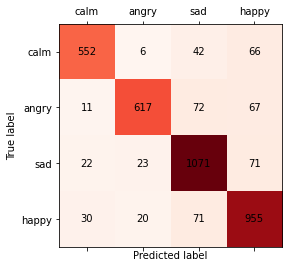

In [94]:
C = confusion_matrix(test_label, Audio_classifier.predict(Audio_test_feature))
plt.matshow(A=C, cmap=plt.cm.Reds) 
for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')  
plt.xticks(range(0,4), labels=['calm','angry','sad','happy']) 
plt.yticks(range(0,4), labels=['calm','angry','sad','happy'])

## 3. Music Emotion Detection based on Lyrics

In [16]:
import neattext.functions as nfx
import sqlite3

from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### 3.1 Data Pre-processing
#### 3.1.1 Importing the musiXmatch dataset

In [1156]:
conn = sqlite3.connect('mxm_dataset.db')
query = "SELECT * FROM lyrics"
mxm_dataset_df = pd.read_sql(query, conn)
mxm_dataset_df

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0
1,TRAAAAV128F421A322,4623710,the,4,0
2,TRAAAAV128F421A322,4623710,you,2,0
3,TRAAAAV128F421A322,4623710,to,2,0
4,TRAAAAV128F421A322,4623710,and,5,0
...,...,...,...,...,...
19045327,TRZZZZD128F4236844,2466899,easili,1,1
19045328,TRZZZZD128F4236844,2466899,disast,1,1
19045329,TRZZZZD128F4236844,2466899,frown,1,1
19045330,TRZZZZD128F4236844,2466899,teas,1,1


#### 3.1.2 Collating the dataset into lyrics

In [1615]:
lyrics_list=[]
count = 1
track_id = valence_arousal_df["MSD_track_id"].values
for name in track_id:
    text=""
    one_file_lyrics_df = mxm_dataset_df[mxm_dataset_df["track_id"]==name].reset_index()
    for i, word in enumerate(one_file_lyrics_df["word"]):
        for ite_ in range(one_file_lyrics_df["count"][i]):
            text+=word+" "
    lyrics_list.append(text)
    print(f"Processing lyrics number: {count}, Process completed: {count}/{len(valence_arousal_df)}",end="\r",flush=True)
    count+=1
    
Lyrics_df = pd.DataFrame(lyrics_list,columns=["Lyrics"])
Lyrics_df.to_csv("Extracted_Lyrics_Features.csv")

#### 3.1.3 Extracting labels

In [17]:
with_lyrics_list=[]
lyrics_labels_list=[]
Extracted_Lyrics_Features_df = pd.read_csv("Extracted_Lyrics_Features.csv").drop(columns="Unnamed: 0").fillna(0)

for index, lyrics in enumerate(Extracted_Lyrics_Features_df["Lyrics"]):
    if(lyrics!=0):
        with_lyrics_list.append(lyrics)
        lyrics_labels_list.append(label_df["Labels"][index])
Lyrics_feature_df = pd.DataFrame(with_lyrics_list,columns=["Lyrics"])
Lyrics_label_df = pd.DataFrame(lyrics_labels_list,columns=["Labels"])
Lyrics_dataset_df = pd.concat([Lyrics_feature_df,Lyrics_label_df],axis=1)
Lyrics_dataset_df

,Lyrics,Labels
0,i i i i i i i i the the the the you you you yo...,sad
1,i i i i i i i the the the the the the the the ...,Relaxed
2,i i i i i i i the the the the the the the the ...,Relaxed
3,i i i the the the the you you you you you to t...,happy
4,i i i the the the the you you you you you to t...,happy
...,...,...
12316,i i i i i i the you you you you you you you yo...,angry
12317,i i i i i i the you you you you you you you yo...,angry
12318,the the the the the the the the the the the th...,Relaxed
12319,i the the the the the the you you you you you ...,happy


#### 3.1.4 Removing stopwords and odd short words

In [18]:
Lyrics_dataset_df['Clean_Text'] = Lyrics_dataset_df['Lyrics'].apply(nfx.remove_stopwords)
Lyrics_dataset_df['Clean_Text'] = Lyrics_dataset_df['Clean_Text'].apply(nfx.remove_shortwords)

#### 3.1.5 Stemming

In [1232]:
Stemmer = PorterStemmer() 
Lyrics_dataset_df['Clean_Text'] = Lyrics_dataset_df['Clean_Text'].apply(Stemmer.stem)

#### 3.1.6 Lemmatization

In [1256]:
lemmatizer = WordNetLemmatizer() 
Lyrics_dataset_df['Clean_Text'] = Lyrics_dataset_df['Clean_Text'].apply(lemmatizer.lemmatize)

In [19]:
Lyrics_dataset_df

,Lyrics,Labels,Clean_Text
0,i i i i i i i i the the the the you you you yo...,sad,find find said said hold head someth someth ma...
1,i i i i i i i the the the the the the the the ...,Relaxed,know know know like like heart need look thing...
2,i i i i i i i the the the the the the the the ...,Relaxed,know know know like like heart need look thing...
3,i i i the the the the you you you you you to t...,happy,love love love love know know feel tell tell a...
4,i i i the the the the you you you you you to t...,happy,love love love love know know feel tell tell a...
...,...,...,...
12316,i i i i i i the you you you you you you you yo...,angry,love like like come want want think think head...
12317,i i i i i i the you you you you you you you yo...,angry,love like like come want want think think head...
12318,the the the the the the the the the the the th...,Relaxed,know know know know know know know know know k...
12319,i the the the the the the you you you you you ...,happy,like like like like like come come come come c...


### 3.2 Feature Extraction
#### 3.2.1 Count Vectorizer

In [20]:
Count_Vectorizer = CountVectorizer()
Count_Vector = Count_Vectorizer.fit_transform(Lyrics_dataset_df["Clean_Text"])
Count_Vector = Count_Vector.toarray()

In [21]:
Count_Vector.shape

(12321, 3287)

#### 3.2.2 TF-IDF Vectorizer

In [22]:
Tfidf_Vectorizer = TfidfVectorizer()
Tfidf_Vector = Tfidf_Vectorizer.fit_transform(Lyrics_dataset_df["Clean_Text"])
Tfidf_Vector = Tfidf_Vector.toarray()

In [23]:
Tfidf_Vector.shape

(12321, 3287)

### 3.3 Defining training and test dataset

In [60]:
CV_train_feature,CV_test_feature = train_test_split(Count_Vector,
                                                    test_size=3696,train_size=8625,random_state=42)

Tfidf_train_feature,Tfidf_test_feature = train_test_split(Tfidf_Vector,
                                                          test_size=3696,train_size=8625,random_state=42)

train_label,test_label = train_test_split(Lyrics_dataset_df['Labels'],
                                          test_size=3696,train_size=8625,random_state=42)

### 3.4 Training Models

In [61]:
CV_knn_clf = KNeighborsClassifier(n_neighbors=99).fit(CV_train_feature,train_label)
CV_svm_clf = SVC().fit(CV_train_feature,train_label)
CV_mlp_clf = MLPClassifier(max_iter=300,random_state=42).fit(CV_train_feature,train_label)
CV_rfc_clf = RandomForestClassifier().fit(CV_train_feature,train_label)

CV_ens_clf = VotingClassifier(
              estimators=[('knn',CV_knn_clf),('svm',CV_svm_clf),('mlp',CV_mlp_clf),('rf',CV_rfc_clf)],
              voting='hard').fit(CV_train_feature,train_label)

In [62]:
Tfidf_knn_clf = KNeighborsClassifier(n_neighbors=99).fit(Tfidf_train_feature,train_label)
Tfidf_svm_clf = SVC().fit(Tfidf_train_feature,train_label)
Tfidf_mlp_clf = MLPClassifier(max_iter=300,random_state=42).fit(Tfidf_train_feature,train_label)
Tfidf_rfc_clf = RandomForestClassifier().fit(Tfidf_train_feature,train_label)

Tfidf_ens_clf = VotingClassifier(
              estimators=[('knn',Tfidf_knn_clf),('svm',Tfidf_svm_clf),('mlp',Tfidf_mlp_clf),('rf',Tfidf_rfc_clf)],
              voting='hard').fit(Tfidf_train_feature,train_label)

### 3.5 Making Predictions

In [63]:
CV_knn_acc = CV_knn_clf.score(CV_test_feature,test_label)
CV_svm_acc = CV_svm_clf.score(CV_test_feature,test_label)
CV_mlp_acc = CV_mlp_clf.score(CV_test_feature,test_label)
CV_rfc_acc = CV_rfc_clf.score(CV_test_feature,test_label)
CV_ens_acc = CV_ens_clf.score(CV_test_feature,test_label)

In [64]:
Tfidf_knn_acc = Tfidf_knn_clf.score(Tfidf_test_feature,test_label)
Tfidf_svm_acc = Tfidf_svm_clf.score(Tfidf_test_feature,test_label)
Tfidf_mlp_acc = Tfidf_mlp_clf.score(Tfidf_test_feature,test_label)
Tfidf_rfc_acc = Tfidf_rfc_clf.score(Tfidf_test_feature,test_label)
Tfidf_ens_acc = Tfidf_ens_clf.score(Tfidf_test_feature,test_label)

In [65]:
CV_acc = pd.DataFrame([CV_knn_acc,CV_svm_acc,CV_mlp_acc,CV_rfc_acc,CV_ens_acc],
                       columns=["Count Vector Accuracy"])
Tfidf_acc = pd.DataFrame([Tfidf_knn_acc,Tfidf_svm_acc,Tfidf_mlp_acc,Tfidf_rfc_acc,Tfidf_ens_acc],
                       columns=["TF-IDF Accuracy"])

### 3.6 Analysis

In [99]:
Lyrics_summary = pd.concat([Clf_name_df,CV_acc,Tfidf_acc],axis=1)
Lyrics_summary

,Classifiers,Count Vector Accuracy,TF-IDF Accuracy
0,KNN,0.331710,0.365260
1,SVM,0.690747,0.818994
2,MLP,0.834145,0.834416
3,Random Forest,0.854708,0.850649
4,Ensemble,0.843885,0.848214


([<matplotlib.axis.YTick at 0x7f603841e850>,
 [Text(0, 0, 'calm'),
  Text(0, 1, 'angry'),
  Text(0, 2, 'sad'),
  Text(0, 3, 'happy')])

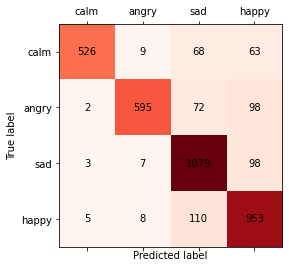

In [96]:
C = confusion_matrix(test_label, Lyrics_classifier.predict(Lyrics_test_feature))
plt.matshow(A=C, cmap=plt.cm.Reds) 
for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')  
plt.xticks(range(0,4), labels=['calm','angry','sad','happy']) 
plt.yticks(range(0,4), labels=['calm','angry','sad','happy'])

## 4. Music Emotion Detection based on Audio and Lyrics
### 4.1 Method 1: Feature Fusion
#### 4.1.1 Filter data with both audio and lyrics

In [22]:
Extracted_Lyrics_Features_df = pd.read_csv("Extracted_Lyrics_Features.csv").drop(columns="Unnamed: 0").fillna(0)

In [27]:
with_lyrics_list=[]
with_audio_list = []
labels_list=[]
for index, lyrics in enumerate(Extracted_Lyrics_Features_df["Lyrics"]):
    if(lyrics!=0):
        with_lyrics_list.append(lyrics)
        with_audio_list.append(Normalized_feature_df.to_numpy()[index])
        labels_list.append(label_df["Labels"][index])
Audio_feature_df = pd.DataFrame(with_audio_list,columns=Normalized_feature_df.columns)
Lyrics_feature_df = pd.DataFrame(with_lyrics_list,columns=["Lyrics"])
Fusion_label_df = pd.DataFrame(labels_list,columns=["Labels"])

In [28]:
Lyrics_feature = Count_Vector
Audio_feature = Audio_feature_df.to_numpy()

#### 4.1.2 Normalizing the lyrics data

In [29]:
title_list = []
for i in range(len(Lyrics_feature[0])):
    title_list.append("Feature "+str(i))
Lyrics_feature_df = pd.DataFrame(Lyrics_feature,columns=title_list)

Normalized_Lyrics_feature_df = pd.DataFrame()
for i in Lyrics_feature_df.columns:
    max_ = np.amax(Lyrics_feature_df[i])
    min_ = np.amin(Lyrics_feature_df[i])
    #std = np.std(feature_df[i])
    normlist = (Lyrics_feature_df[i]-min_)/(max_-min_)
    Normalized_Lyrics_feature_df = pd.concat([Normalized_Lyrics_feature_df,normlist],axis=1).fillna(0)
Normalized_Lyrics_feature = Normalized_Lyrics_feature_df.to_numpy()

#### 4.1.3 Features concatenation

In [30]:
Fusion_feature = np.hstack([Audio_feature,Normalized_Lyrics_feature])
Fusion_feature.shape

(12321, 3307)

#### 4.1.4 Defining training and test dataset

In [31]:
Fusion_train_feature,Fusion_test_feature = train_test_split(Fusion_feature,
                                                    test_size=3696,train_size=8625,random_state=42)

Fusion_train_label,Fusion_test_label = train_test_split(Fusion_label_df['Labels'],
                                          test_size=3696,train_size=8625,random_state=42)

#### 4.1.5 Training models

In [32]:
Fusion_knn_clf = KNeighborsClassifier(n_neighbors=99).fit(Fusion_train_feature,Fusion_train_label)
Fusion_svm_clf = SVC().fit(Fusion_train_feature,Fusion_train_label)
Fusion_mlp_clf = MLPClassifier(max_iter=300,random_state=42).fit(Fusion_train_feature,Fusion_train_label)
Fusion_rfc_clf = RandomForestClassifier().fit(Fusion_train_feature,Fusion_train_label)

Fusion_ens_clf = VotingClassifier(
              estimators=[('knn',Fusion_knn_clf),('svm',Fusion_svm_clf),('mlp',Fusion_mlp_clf),('rf',Fusion_rfc_clf)],
              voting='hard').fit(Fusion_train_feature,Fusion_train_label)

#### 4.1.6 Making predictions

In [33]:
Fusion_knn_acc = Fusion_knn_clf.score(Fusion_test_feature,Fusion_test_label)
Fusion_svm_acc = Fusion_svm_clf.score(Fusion_test_feature,Fusion_test_label)
Fusion_mlp_acc = Fusion_mlp_clf.score(Fusion_test_feature,Fusion_test_label)
Fusion_rfc_acc = Fusion_rfc_clf.score(Fusion_test_feature,Fusion_test_label)
Fusion_ens_acc = Fusion_ens_clf.score(Fusion_test_feature,Fusion_test_label)

In [34]:
Feature_fusion_acc = pd.DataFrame([Fusion_knn_acc,Fusion_svm_acc,Fusion_mlp_acc,Fusion_rfc_acc,Fusion_ens_acc],
                       columns=["Feature fusion Accuracy"])

#### 4.1.7 Analysis

In [35]:
Feature_fusion_acc

,Feature fusion Accuracy
0,0.427219
1,0.675866
2,0.836580
3,0.868236
4,0.844968


([<matplotlib.axis.YTick at 0x7f60278388e0>,
 [Text(0, 0, 'calm'),
  Text(0, 1, 'angry'),
  Text(0, 2, 'sad'),
  Text(0, 3, 'happy')])

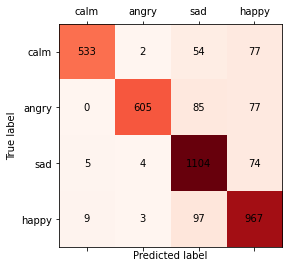

In [97]:
C = confusion_matrix(Fusion_test_label, Fusion_rfc_clf.predict(Fusion_test_feature))
plt.matshow(A=C, cmap=plt.cm.Reds) 
for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')  
plt.xticks(range(0,4), labels=['calm','angry','sad','happy']) 
plt.yticks(range(0,4), labels=['calm','angry','sad','happy'])

### 4.2 Method 2: Decision Fusion

In [41]:
from sklearn.metrics import accuracy_score

#### 4.2.1 Defining training and test dataset

In [36]:
Lyrics_train_feature,Lyrics_test_feature = train_test_split(Lyrics_feature,test_size=3696,train_size=8625,random_state=42)
Audio_train_feature,Audio_test_feature = train_test_split(Audio_feature,test_size=3696,train_size=8625,random_state=42)
train_label,test_label = train_test_split(Fusion_label_df,test_size=3696,train_size=8625,random_state=42)

#### 4.2.2 Training models

In [37]:
Audio_classifier = RandomForestClassifier().fit(Audio_train_feature,train_label)
Lyrics_classifier = RandomForestClassifier().fit(Lyrics_train_feature,train_label)

#### 4.2.3 Make predictions

In [38]:
Audio_pred = Audio_classifier.predict_proba(Audio_test_feature)
Lyrics_pred = Lyrics_classifier.predict_proba(Lyrics_test_feature)

#### 4.2.4 Decision fusion

In [39]:
Decision_fusion_pred = Audio_pred + Lyrics_pred

In [42]:
pred_result_list=[]
for row in Decision_fusion_pred:
    pred_result = np.argmax(row)
    pred_result_list.append(Audio_classifier.classes_[pred_result])
pred_result_array = np.array(pred_result_list)
Decision_fusion_acc = accuracy_score(test_label, pred_result_array)

#### 4.2.5 Analysis

In [43]:
Decision_fusion_acc

0.8717532467532467

([<matplotlib.axis.YTick at 0x7f6024feb400>,
 [Text(0, 0, 'calm'),
  Text(0, 1, 'angry'),
  Text(0, 2, 'sad'),
  Text(0, 3, 'happy')])

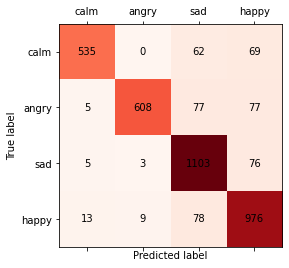

In [79]:
C = confusion_matrix(test_label, pred_result_array)
plt.matshow(A=C, cmap=plt.cm.Reds) 


for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.ylabel('True label')
plt.xlabel('Predicted label')
    
plt.xticks(range(0,4), labels=['calm','angry','sad','happy']) 
plt.yticks(range(0,4), labels=['calm','angry','sad','happy'])

## 5. Comparison

### 5.1 Audio only

In [68]:
Clf_name=["KNN","SVM","MLP","Random Forest","Ensemble"]
Clf_name_df = pd.DataFrame(Clf_name,columns = ["Classifiers"])
Audio_summary = pd.concat([Clf_name_df,Raw_acc,Norm_acc,PCA_acc],axis=1)
Audio_summary

,Classifiers,Raw Accuracy,Norm Accuracy,PCA Accuracy
0,KNN,0.570136,0.444943,0.444535
1,SVM,0.409404,0.469413,0.492251
2,MLP,0.310840,0.475122,0.497145
3,Random Forest,0.867598,0.729201,0.721860
4,Ensemble,0.696833,0.565253,0.579935


### 5.2 Lyrics only

In [69]:
Lyrics_summary = pd.concat([Clf_name_df,CV_acc,Tfidf_acc],axis=1)
Lyrics_summary

,Classifiers,Count Vector Accuracy,TF-IDF Accuracy
0,KNN,0.331710,0.365260
1,SVM,0.690747,0.818994
2,MLP,0.834145,0.834416
3,Random Forest,0.854708,0.850649
4,Ensemble,0.843885,0.848214


### 5.3 Audio + Lyrics

In [71]:
Acc_list = [raw_rfc_acc, CV_rfc_acc, Fusion_rfc_acc, Decision_fusion_acc]
method_list = ["Audio only","Lyrics only","Feature fusion","Decision fusion"]
Acc_df = pd.DataFrame(Acc_list,columns=["Accuracy"])
method_df = pd.DataFrame(method_list,columns=["Methods"])
Fusion_summary_df = pd.concat([method_df,Acc_df],axis=1)
Fusion_summary_df

,Methods,Accuracy
0,Audio only,0.867598
1,Lyrics only,0.854708
2,Feature fusion,0.868236
3,Decision fusion,0.871753


## 6. Music Mood Tracking
### 6.1 Audio Segmentation

In [90]:
test_audio_path = 'Test_music.mp3'
y, sr = librosa.load(test_audio_path)

segment_duration = 10 
overlap_duration = 2 

segment_samples = int(segment_duration * sr)
overlap_samples = int(overlap_duration * sr)
total_samples = len(y)

segments = []
start = 0
while start + segment_samples < total_samples:
    segment = y[start:start+segment_samples]
    segments.append(segment)
    start += segment_samples - overlap_samples

print("Number of segments:", len(segments))

Number of segments: 21


### 6.2 Audio Feature Extraction

In [91]:
count = 0
Seg_list=[]
for seg in segments:
    Seg_features_list=[]
    S = np.abs(librosa.stft(seg))
    tempo, beats = librosa.beat.beat_track(y=seg, sr=sr)          
    melspectrogram = librosa.feature.melspectrogram(y=seg, sr=sr) 
    mfcc = librosa.feature.mfcc(y=seg, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    chroma_stft = librosa.feature.chroma_stft(y=seg, sr=sr)
    chroma_cq = librosa.feature.chroma_cqt(y=seg, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=seg, sr=sr)
    rms = librosa.feature.rms(y=seg)                              
    cent = librosa.feature.spectral_centroid(y=seg, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=seg, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=seg, sr=sr)
    poly_features = librosa.feature.poly_features(S=S, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=seg, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(seg)
    harmonic = librosa.effects.harmonic(seg)                      
    percussive = librosa.effects.percussive(seg)
    onset_frames = librosa.onset.onset_detect(y=seg, sr=sr)
    frames_to_time = librosa.frames_to_time(onset_frames[:20], sr=sr)
    
    Seg_features_list.append((tempo-min_list[0])/(max_list[0]-min_list[0]))  # tempo
    Seg_features_list.append((sum(beats)-min_list[1])/(max_list[1]-min_list[1]))    # beats
    Seg_features_list.append((np.average(beats)-min_list[2])/(max_list[2]-min_list[2]))  
    Seg_features_list.append((np.mean(melspectrogram)-min_list[3])/(max_list[3]-min_list[3]) )   # melspectrogram
    Seg_features_list.append((np.mean(mfcc)-min_list[4])/(max_list[4]-min_list[4]))    # mfcc
    Seg_features_list.append((np.mean(mfcc_delta)-min_list[5])/(max_list[5]-min_list[5]))    # mfcc delta
    Seg_features_list.append((np.mean(chroma_stft)-min_list[6])/(max_list[6]-min_list[6]))  #pitches mean
    Seg_features_list.append((np.mean(chroma_cq)-min_list[7])/(max_list[7]-min_list[7]))  #pitches mean 
    Seg_features_list.append((np.mean(chroma_cens)-min_list[8])/(max_list[8]-min_list[8])) 
    Seg_features_list.append((np.mean(rms)-min_list[9])/(max_list[9]-min_list[9]))    # rms
    Seg_features_list.append((np.mean(cent)-min_list[10])/(max_list[10]-min_list[10])) 
    Seg_features_list.append((np.mean(spec_bw)-min_list[11])/(max_list[11]-min_list[11])) 
    Seg_features_list.append((np.mean(contrast)-min_list[12])/(max_list[12]-min_list[12])) 
    Seg_features_list.append((np.mean(rolloff)-min_list[13])/(max_list[13]-min_list[13])) 
    Seg_features_list.append((np.mean(poly_features)-min_list[14])/(max_list[14]-min_list[14])) 
    Seg_features_list.append((np.mean(tonnetz)-min_list[15])/(max_list[15]-min_list[15])) 
    Seg_features_list.append((np.mean(zcr)-min_list[16])/(max_list[16]-min_list[16]))    # zero crossing rate
    Seg_features_list.append((np.mean(harmonic)-min_list[17])/(max_list[17]-min_list[17]))    # harmonic
    Seg_features_list.append((np.mean(percussive)-min_list[18])/(max_list[18]-min_list[18]))    # percussive
    Seg_features_list.append((np.mean(frames_to_time)-min_list[19])/(max_list[19]-min_list[19]))  # frames
    
    Seg_features_array = np.array(Seg_features_list)
    Seg_list.append(Seg_features_array)
    
    count+=1
    print(f"Processing audio number: {count}, Process completed: {count}/{len(segments)}",end="\r",flush=True)

### 6.3 Making predictions

In [92]:
seg_pred_result_list = []
for seg_feature in Seg_list:
    seg_pred_result_list.append(Audio_classifier.predict(seg_feature.reshape(1,20)))

In [93]:
seg_pred_result_list

[array(['angry'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['angry'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['angry'], dtype=object),
 array(['Relaxed'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['Relaxed'], dtype=object),
 array(['sad'], dtype=object),
 array(['Relaxed'], dtype=object),
 array(['angry'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['sad'], dtype=object),
 array(['angry'], dtype=object),
 array(['sad'], dtype=object)]

## 7. Conclusion
In this project, I designed several experiments. The unimodal music emotion recognition experiments show that for independent audio features and lyric features, the model with the best recognition is random forest, and the recognition of audio is slightly better than that of lyric. Multimodal music emotion recognition experiments demonstrate that multimodal emotion recognition is more effective than unimodal. In addition, the recognition accuracy using decision fusion is higher than that of using feature fusion, and is the best among all the methods used in this project.

At the mean time, I also found the problem of uneven distribution of the number of species samples leading to biased prediction results through this experiment. I will focus on exploring ways to solve this problem in the future.